In [1]:
%load_ext autoreload
%autoreload 2

from ml4a import image
from ml4a.utils import face
from ml4a.models import idinvert

Display aligned face


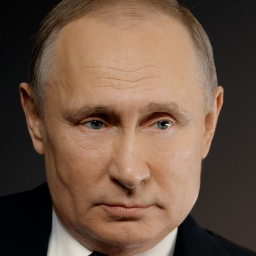

In [2]:
img = image.load_image('https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/Vladimir_Putin_%282020-02-20%29.jpg/1200px-Vladimir_Putin_%282020-02-20%29.jpg')
target_image, face_found = face.align_face(img, face_width=idinvert.resolution)
image.display(target_image, title="Display aligned face")


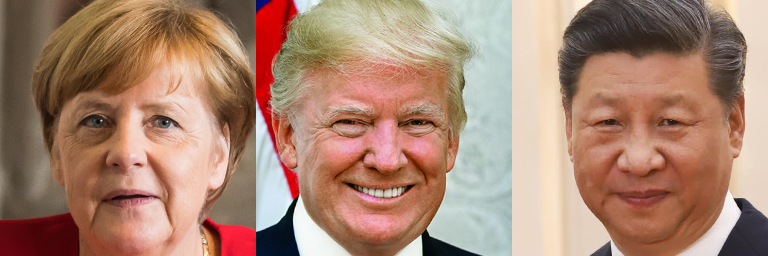

In [3]:
context_paths = [
    'https://upload.wikimedia.org/wikipedia/commons/a/a8/Angela_Merkel_2019_%28cropped%29.jpg',
    'https://bookstore.gpo.gov/sites/default/files/styles/product_page_image/public/covers/potus2_0.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/3/32/Xi_Jinping_2019.jpg'    
]

context_images = []
for path in context_paths:
    img = image.load_image(path)
    aligned_face, face_found = face.align_face(img, face_width=idinvert.resolution)
    if face_found:
        context_images.append(aligned_face)

image.display(context_images)

[2020-11-06 14:48:42,593][INFO] Build network for module `generator` in model `styleganinv_ffhq256`.
[2020-11-06 14:48:42,733][INFO] Loading pytorch weights from `/home/bzion/.ml4a/models/idinvert_pytorch/styleganinv_ffhq256_generator.pth`.
[2020-11-06 14:48:42,852][INFO] Successfully loaded!
[2020-11-06 14:48:44,560][INFO] Current `lod` is 0.0.
[2020-11-06 14:48:44,561][INFO] Build network for module `encoder` in model `styleganinv_ffhq256`.
[2020-11-06 14:48:45,372][INFO] Loading pytorch weights from `/home/bzion/.ml4a/models/idinvert_pytorch/styleganinv_ffhq256_encoder.pth`.
[2020-11-06 14:48:46,306][INFO] Successfully loaded!


loss_pix: 0.005, loss_feat: 283.989, loss: 0.019: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]

superimposed images


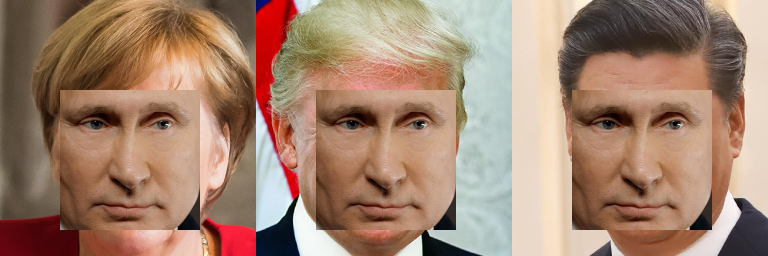

diffused images


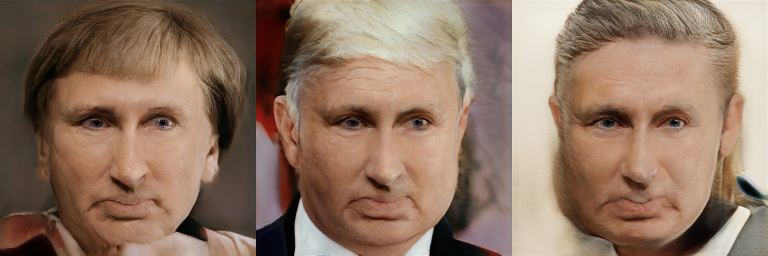

In [4]:
showed_fuses, diffused_images = idinvert.fuse('styleganinv_ffhq256', 
                                              context_images, target_image, 
                                              crop_size=140, center_x=130, center_y=160)
image.display(showed_fuses, title="superimposed images")
image.display(diffused_images, title="diffused images")

In [5]:
latent_code = idinvert.invert('styleganinv_ffhq256', target_image, redo=False, save=False)

previous code found at /home/bzion/.ml4a/models/idinvert/reconstructions/b40ef68324327d557ad72da7c0d50776.npy, skip inversion (set redo=True to overwrite)


[2020-11-06 14:49:01,081][INFO] Build network for module `generator` in model `styleganinv_ffhq256`.
[2020-11-06 14:49:01,230][INFO] Loading pytorch weights from `/home/bzion/.ml4a/models/idinvert_pytorch/styleganinv_ffhq256_generator.pth`.
[2020-11-06 14:49:01,348][INFO] Successfully loaded!
[2020-11-06 14:49:01,380][INFO] Current `lod` is 0.0.


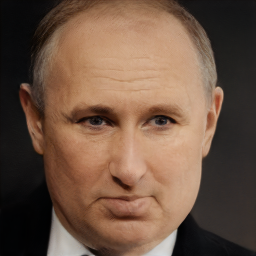

In [6]:
reconstruction = idinvert.generate('styleganinv_ffhq256', latent_code)
image.display(reconstruction)

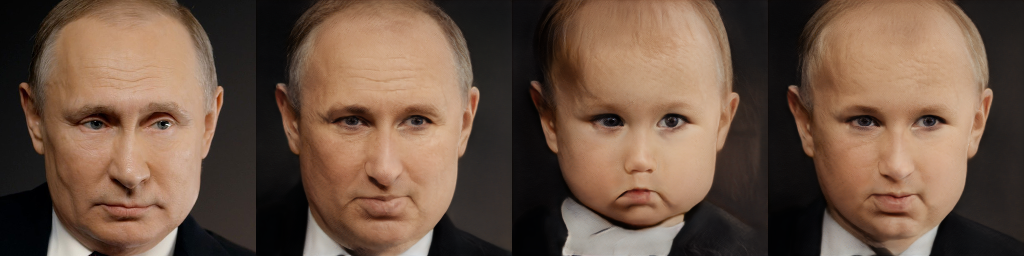

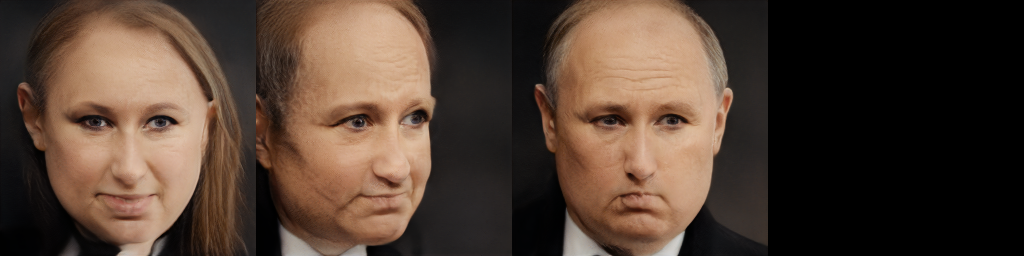

In [7]:
reconstruction_age = idinvert.generate('styleganinv_ffhq256', idinvert.age(latent_code, -2.5))
reconstruction_eyeglasses = idinvert.generate('styleganinv_ffhq256', idinvert.eyeglasses(latent_code, -2.5))
reconstruction_gender = idinvert.generate('styleganinv_ffhq256', idinvert.gender(latent_code, -2.5))
reconstruction_pose = idinvert.generate('styleganinv_ffhq256', idinvert.pose(latent_code, -2.5))
reconstruction_expression = idinvert.generate('styleganinv_ffhq256', idinvert.expression(latent_code, -2.5))

image.display([
    target_image, 
    reconstruction[0],
    reconstruction_age[0], 
    reconstruction_eyeglasses[0],
    reconstruction_gender[0],
    reconstruction_pose[0],
    reconstruction_expression[0]    
])

In [8]:
import numpy as np

frames = [idinvert.generate('styleganinv_ffhq256', idinvert.age(latent_code, r))[0] 
          for r in np.linspace(-2.5, +2.5, 100)]
image.display(frames, animate=True, title="Age range")

In [9]:
frames = [idinvert.generate('styleganinv_ffhq256', idinvert.expression(latent_code, r))[0] 
          for r in np.linspace(-3.0, +3.0, 100)]
image.display(frames, animate=True, title="Expression range")